# Level 1 Requirement Flowdown Overview

## L1-3 Global Fluxes (Global Mode)

> Carbon-I shall obtain column averaged mixing ratios with a standard error ($ \sigma_{agg} $) of <14 ppb CH₄, < 3.5ppm for CO₂,
and <10 ppb for CO once averaged to a 12 km × 12 km grid for over 50% of such grid cells in the tropics¹ each month.

¹: Requirement defined in the tropics (land regions between 10°S to 10°N). 

---

## Overview
This notebook demonstrates how we propagate top-level science requirements (L1 requirements) down to specific instrument specifications (e.g., readout noise, total system efficiency, etc.). In short, we start from a desired measurement precision on the **proxy gas** (like N₂O or CH₄) and systematically convert that into constraints on photon-collection efficiency, detector quantum efficiency, readout noise, and other instrument parameters. The result is an iterative process to ensure the instrument’s design meets the required performance with sufficient margin.

## Conclusion
This flowdown captures how the **Carbon-I** instrument’s core parameters—efficiency, readout noise, integration time, and so on—tie directly back to the mission’s main science requirement: measuring the proxy-gas concentration with a certain precision. By carefully tracing through these links, we confirm that the instrument design, as captured by the current best estimates (CBE), is aligned with achieving the Level-1 science targets.

---

Set up the programming environment

In [1]:
# This Cell is used to set up the environment for the Carbon-I Open Source project.
include("setup-level1-packages.jl")
# This includes our Carbon-I and vSmartMOM packages (developed by our team)

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


req_vs_exp_table

---

### Define Requirements with corresponding units:

We utilize Julia's Unitful package here, which allows for automated unit conversion and propagation of units for any computation. 

In [2]:
# Define numbers from L1 Requirements

# Global Mode (L1-3) Aggregated Standard Error (ASE) requirements:
global_mode_ch4_error = 14.0u"ppb"           
global_mode_co2_error = 3.5u"ppm"            
global_mode_co_error  = 10.0u"ppb"            

# Specify spatial aggregation scale (here, our finest global model resolution grid cell)
global_mode_grid_resolution = [12e3u"m", 12e3u"m"]  
global_mode_coverage = 0.5  # in fraction (unitless), will never be used as our data statistics is already using the median, i.e. the 50%ile.

# Specify Ground Sampling Distance GSD in along x cross track directions, for Required and CBE cases:
global_mode_gsd_req  = [400.0u"m", 400.0u"m"]   
global_mode_gsd_cbe  = [303.0u"m", 345.0u"m"]   

# Reference Background VMRs
background_vmr_ch4 = 1900.0u"ppb"  
background_vmr_co2 = 420.0u"ppm"   
background_vmr_n2o = 330.0u"ppb";   

### Obtain cloud statistics
Derived from our Data drought in the humid tropics GRL paper

In [3]:
# Read cloud median statistics in 10S-10N from Yinon (Data Drought paper)
# Note that this statistics ensures the 50%ile requirement as defined in the L1 Requirement
cs = readdlm("../../data/CloudStatsCentralAmazonia.dat");

# Create an interpolation function for the cloud statistics (as function of gsd)
cf_interp = LinearInterpolation(cs[:,1]u"m", cs[:,2], extrapolation_bc=Line());

# Define the range of GSDs to use for the cloud statistics
gsds = (30:10:1000)u"m";

In [4]:
# Compute effective pixel sizes as the square root of the product of along and cross track GSDs:
req_pix = sqrt(prod(global_mode_gsd_req))
cbe_pix = sqrt(prod(global_mode_gsd_cbe));

In [5]:
# Compute the conservative cloud-free fraction for the required and CBE pixel sizes (un %)
req_fcl = 100cf_interp(req_pix)
cbe_fcl = 100cf_interp(cbe_pix)

5.311616895386162

┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packa

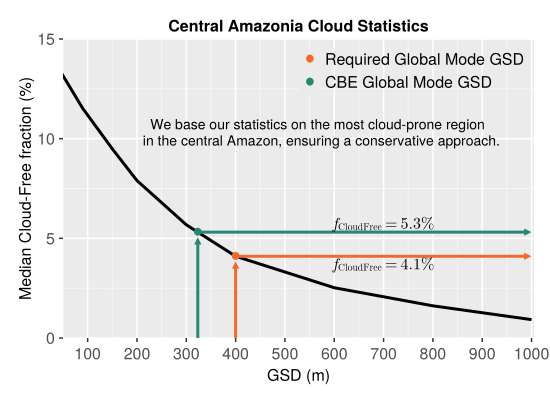

In [6]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="GSD (m)", ylabel="Median Cloud-Free fraction (%)", xticks = 0:100:1000, title="Central Amazonia Cloud Statistics")
lines!(ax, ustrip(gsds), 100cf_interp.(gsds), color=:black, linewidth=3)

scatter!(ax, ustrip(req_pix), req_fcl, markersize = 10, marker = :circ, color = CarbonI_colors[5], label="Required Global Mode GSD")
scatter!(ax, ustrip(cbe_pix), cbe_fcl, markersize = 10, marker = :circ, color = CarbonI_colors[3], label="CBE Global Mode GSD")

arrows!(ax, [ustrip(req_pix),],[0,],[0,],[ustrip(req_fcl)-0.5,],arrowsize = 10, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [ustrip(req_pix),],[ustrip(req_fcl),] ,[1000-ustrip(req_pix)-10,],[0,],arrowsize = 10, linewidth=3, color = CarbonI_colors[5])

arrows!(ax, [ustrip(cbe_pix),],[0,],[0,],[ustrip(cbe_fcl)-0.5,],arrowsize = 10, linewidth=3, color = CarbonI_colors[3])
arrows!(ax, [ustrip(cbe_pix),],[ustrip(cbe_fcl),] ,[1000-ustrip(cbe_pix)-10,],[0,],arrowsize = 10, linewidth=3, color = CarbonI_colors[3])

rounded_val = @sprintf("%1.1f", req_fcl)
# Build the full string with proper escapes:
full_label_str = "\$f_{\\text{CloudFree}} = $rounded_val \\text{%}\$"
# Convert it to a LaTeXString.
full_label = latexstring(full_label_str)
text!(ax, full_label, position = (700, req_fcl), align = (:center, :top), color = :black)
rounded_val = @sprintf("%1.1f", cbe_fcl)
# Build the full string with proper escapes:
full_label_str = "\$f_{\\text{CloudFree}} = $rounded_val \\text{%}\$"
# Convert it to a LaTeXString.
full_label = latexstring(full_label_str)
text!(ax, full_label, position = (700, cbe_fcl), align = (:center, :bottom), color = :black)

text!(ax, "We base our statistics on the most cloud-prone region \n in the central Amazon, ensuring a conservative approach.", position = (570, 9.5), align = (:center, :bottom), color = :black, fontsize=14)

xlims!(ax, 50, 1005)
ylims!(ax, 0, 15)
axislegend(ax,position = :rt)
save("../../plots/final/FO-E2-Level1-4-CloudStats.pdf",f)
f
#@show full_label

---
### Define the number of potential measurements that can be averaged over the defined aggregation domain

Now we can compute the potential number of footprints in the global grid, i.e.
$$
N_{max} = \frac{GSD_x \times GSD_y}{Grid_x \times Grid_y}
$$

In [7]:
# Maximum number of global ground pixels in the 12km box (units are fully propagated)
# Req.
N_max_global_req = prod(global_mode_grid_resolution)/prod(global_mode_gsd_req);
# At CBE
N_max_global_cbe = prod(global_mode_grid_resolution)/prod(global_mode_gsd_cbe);

### Define the effective number of cloud-free measurements that can be averaged over the aggregation domain
> Apply the conservative cloud statistics in the central Amazon (doscounting that we can tolerate higher sub-pixel clouds)

$$
N_{eff}^{50\%ile} = N_{max} \times f^{median}_\text{cloud free}
$$:

In [8]:
# Number of cloud-free global ground pixels in the 12km box
# Req.
N_eff_global_req = N_max_global_req * cf_interp(sqrt(prod(global_mode_gsd_req)));
# At CBE
N_eff_global_cbe = N_max_global_cbe * cf_interp(sqrt(prod(global_mode_gsd_cbe)));

show_pixels_table(N_max_global_req, N_eff_global_req, N_max_global_cbe, N_eff_global_cbe, grid_label="12km box in Global Mode, tropical Amazon cloud statistics", render=:markdown)

| **Scenario** | **Max pixels in 12km box in Global Mode, tropical Amazon cloud statistics** | **Cloud-free %** | **Effective pixels** |
|:-------------|----------------------------------------------------------------------------:|-----------------:|---------------------:|
| Required     | 900                                                                         | 4.1%             | 37                   |
| CBE          | 1378                                                                        | 5.3%             | 73                   |


--- 
### Theoretical basis for uncertainty propagation

We can now derive the requirement for $\sigma_{s}^{rel}$, as:
$$
\sigma_s^{rel} < \underbrace{\sigma_{agg}^{rel}}_{Required} \times \sqrt{N_{eff}} \,
$$

and note that we derive the 1km average using the proxy method, i.e. the relative error is derived using

$$
\begin{align}
\sigma_s^{\mathrm{rel}}(R) & =  \sqrt{\sigma_{\mathrm{rel}}^2\bigl(\Omega_{{\tiny\mathrm{CH_4,CO_2}}}\bigr)
     +\sigma_{\mathrm{rel}}^2\bigl(\Omega_{\mathrm{N_2O}}\bigr)}\nonumber\\
& \approx  
\sigma_s^{\mathrm{rel}}(\Omega_{\mathrm{N_2O}})
\tag{D--8}
\end{align}
$$

For our derivation here, we actually use a constant conservative factor to account for teh contribution of the relative error of either CO2 or CH4 to the proxy error budget



In [9]:
# Compute the required relative error in the aggregated standard error (only the driving requirement, in our case a choice between CH4 and CO2)
sigma_rel_agg_global_req      =  min(global_mode_ch4_error/background_vmr_ch4 ,  global_mode_co2_error/background_vmr_co2)  # This should effectively be the same relative error for CO2 and CH4

# Compute relative errors for single soundings (holds for proxy derivations)
sigma_rel_SingleSounding_req  =  sigma_rel_agg_global_req * sqrt(N_eff_global_req)  
sigma_rel_SingleSounding_cbe  =  sigma_rel_agg_global_req * sqrt(N_eff_global_cbe)

# Compute CO independently, as proxy is not required for CO
sigma_co_SingleSounding_req   =  global_mode_co_error * sqrt(N_eff_global_req) 


@printf("Required relative error in σ_agg (in percent) : %.3g\n", 100*sigma_rel_agg_global_req)
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)
@printf("Required Single Measurement Precision for CO in ppb for REQ specs: %.3g\n", ustrip(sigma_co_SingleSounding_req))

Required relative error in σ_agg (in percent) : 0.737
Required Single Measurement Precision for N₂O in percent for req. GSD : 4.48
Required Single Measurement Precision for N₂O in percent for CBE specs: 6.3
Required Single Measurement Precision for CO in ppb for REQ specs: 60.7


---

Illustrate that the CH4 or CO2 precisions hardly matter for the relative errors:
$$
\sigma_{\mathrm{rel}}(R)
\;=\;\sqrt{\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{CH_4,CO_2}}\bigr)
+\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{N_2O}}\bigr)\,},
$$

In [10]:
σ_n2o = 3.5 # Error in %
σ_ghg = 0.5 # Error in % (CO2 and CH4, even smaller than that)

σ_rel = sqrt(σ_n2o^2 + σ_ghg^2)
# Compute the factpr enhancement that comes from CH4 or CO2 noise compared to them being noise free
ampl = σ_rel / σ_n2o
@printf("Error Enhancement factor if also considering GHG noise: %.3g", ampl)

Error Enhancement factor if also considering GHG noise: 1.01

In [11]:
# Now we have to set up the fit:
Δwl = 0.01
wl = 2000:Δwl:2400
#@show wlSol
clima_alb = readdlm(CarbonI.albedo_file,',', skipstart=1)
# This is also define in our tropical scenario directly, it basically is a CliMA computed spectrally resolved albedo but adjusted to some minimal albedo values observed in EMIT.
tropical_forest_albedo = CubicSplineInterpolation(300:2400,clima_alb[:,2]*0.663, extrapolation_bc=Interpolations.Flat());

sol  = CubicSplineInterpolation(range(wlSol[1],wlSol[end], length=length(wlSol)),solar_irr, extrapolation_bc=Interpolations.Flat());
solarIrr = sol.(wl);
refl     = tropical_forest_albedo.(wl);

Now we have to show what instrument specs we require to get to that precision. 
> We can bypass SNR and just use our tropical reference scene (with spectrally varying albedo) and compute $ \sigma $ as function of total system efficiency (i.e. optical throughput and $ Q_e $)

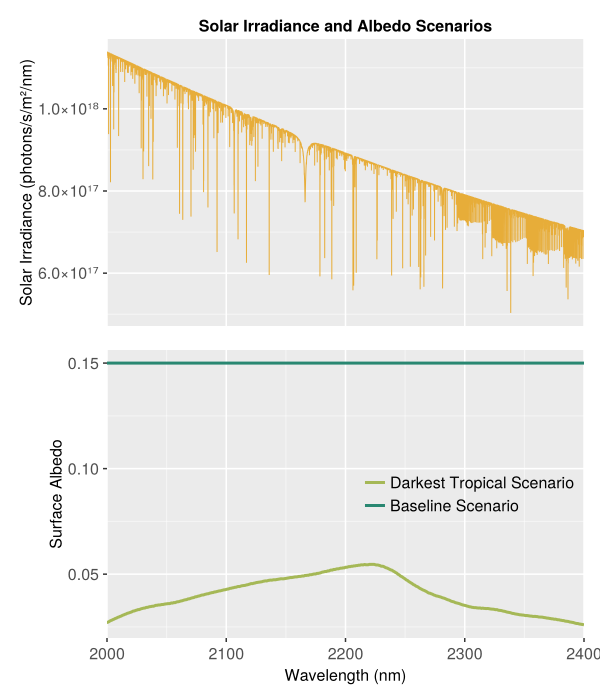

In [12]:
f = Figure(resolution=(600,700))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Solar Irradiance (photons/s/m²/nm)",  title="Solar Irradiance and Albedo Scenarios")
lines!(ax, wl,  solarIrr/1000 .* wl * 1e-9/ (6.626e-34 * 2.998e8), color=CarbonI_colors[1], linewidth=1)
ax2 = Axis(f[2,1], xlabel="Wavelength (nm)", ylabel="Surface Albedo")
lines!(ax2, wl, tropical_forest_albedo.(wl), color=CarbonI_colors[2], linewidth=3, label="Darkest Tropical Scenario")
lines!(ax2, wl, 0*tropical_forest_albedo.(wl).+0.15, color=CarbonI_colors[3], linewidth=3, label="Baseline Scenario")
#lines!(ax2, wl, darkest_albedo_spline.(wl), color=CarbonI_colors[3], linewidth=2)
xlims!(ax, 2000, 2400)
xlims!(ax2, 2000, 2400)
axislegend(ax2,position = :rc)
hidexdecorations!(ax, grid=false)
f

### Load Scenario and CBE + Required instrument specs

Here, we need to load the stressing scenario, which is defined for the humid tropics (lowest albedos, highest water content, most cloud cover)

In [13]:
# Load stressing scenario (tropical forest)
scenario = CarbonI.stressing_scenario()

req_specs = CarbonI.build_instrument("Requirement") 
cbe_specs = CarbonI.build_instrument("CBE") 

# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);
refl_req   = scenario.surface_albedo(req_specs.modelling_wl);
refl_cbe   = scenario.surface_albedo(cbe_specs.modelling_wl);

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[205.17984, 205.28577, 204.3511, 205.65045, 211.39908, 219.25983, 225.50705, 229.22559, 234.98184, 241.08362, 247.89389, 254.52339, 259.31662, 260.55365, 261.2295, 260.91293, 257.9075, 254.52269, 250.68933, 247.50629, 245.75996, 242.73718, 241.07652, 237.61713, 235.17921, 236.70642, 230.41078, 229.94821, 222.20546, 218.0587, 214.88086, 212.21912, 209.32239, 206.50714, 197.59671, 192.69617, 194.36191, 199.31332, 201.06302, 203.26447, 209.37901, 217.33842, 226.74182, 236.74905, 245.94034, 253.06683, 256.719, 261.30786, 265.14124, 268.4499, 271.63074, 274.55365, 276.77612, 279.03894, 281.011, 282.8612, 284.70425, 286.3738, 287.6122, 288.7355, 289.78403, 290.64203, 290.84982, 291.21863, 292.01584, 293.05814, 294.24646, 295.5233, 296.82358, 298.12357, 299.40927, 300.6187]


In [14]:
# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 


In [15]:
# Setup the data for the required and CBE instrument specifications
soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

# Compute the reflectance spectra for the required and CBE instrument specifications (lowest albedo case)
refl_req   = scenario.surface_albedo(req_specs.modelling_wl);
refl_cbe   = scenario.surface_albedo(cbe_specs.modelling_wl);

In [16]:
# Output albedo at MODIS band center at 2130nm (for reference):
@show scenario.surface_albedo(2130);

scenario.surface_albedo(2130) = 0.046440356364937735


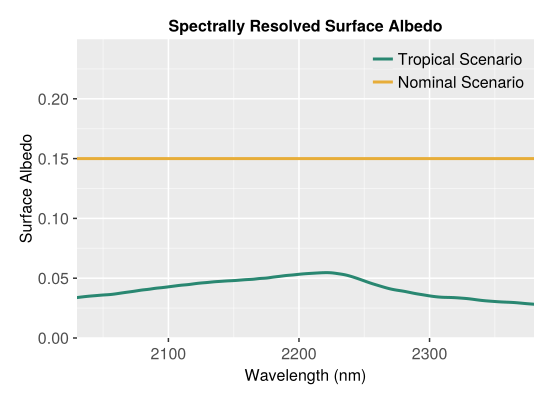

In [17]:
f = Figure(resolution=(550,400))
#ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Solar Irradiance (photons/s/m²/nm)",  title="Solar Irradiance and Tropical Forest Albedo")
#lines!(ax, wl,  solarIrr/1000 .* wl * 1e-9/ (6.626e-34 * 2.998e8), color=CarbonI_colors[1], linewidth=1)
ax2 = Axis(f[1,1],title="Spectrally Resolved Surface Albedo", xlabel="Wavelength (nm)", ylabel="Surface Albedo")
lines!(ax2, wl, scenario.surface_albedo(wl), color=CarbonI_colors[3], linewidth=3, label="Tropical Scenario")
lines!(ax2, wl, 0*tropical_forest_albedo.(wl).+0.15, color=CarbonI_colors[1], linewidth=3, label="Nominal Scenario")
#lines!(ax2, wl, darkest_albedo_spline.(wl), color=CarbonI_colors[3], linewidth=2)
xlims!(ax, 2030, 2380)
xlims!(ax2, 2030, 2380)
ylims!(ax2, 0.0, 0.25)
axislegend(ax2,position = :rt)
hidexdecorations!(ax, grid=false)
save("../../plots/final/Level1-AlbedoScenarios.pdf",f)
f

---

### Compute single measurement precisions for Required and CBE specifications

In [18]:
# This is calling a helper function to calculate precision errors and the Forward model run F(x) for the Required and CBE cases:
# The function calc_rel_error is defined in the common.jl file.
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) ;

In [19]:
# Show CBE expected precisions
md_expected_precisions(error_cbe, sqrt(10); sigdigits=4)

| Gas | Expected single-measurement precision | Unit |
|-----|--------------------------------------:|------|
| CH₄ | 7.188 | ppb |
| CO₂ | 1.266 | ppm |
| CO | 35 | ppb |


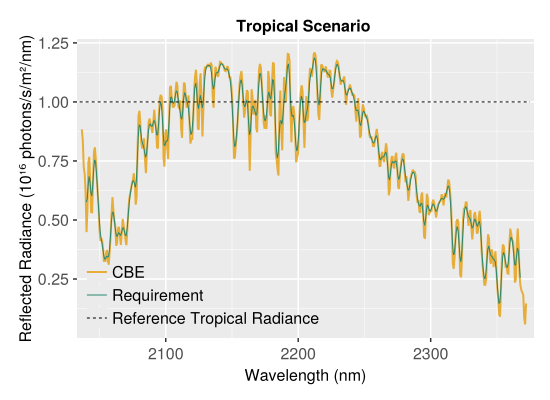

In [20]:
from_w_to_photons = 5.03e12
refRadiance = 1.0e16 # in photons/s/m²/nm

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Reflected Radiance (10¹⁶ photons/s/m²/nm)",  title="Tropical Scenario ")
lines!(ax, cbe_specs.instrument_wl,F_cbe * from_w_to_photons .* cbe_specs.instrument_wl / 1e16, color=CarbonI_colors[1], linewidth=2, label="CBE")
lines!(ax, req_specs.instrument_wl,F_req * from_w_to_photons .* req_specs.instrument_wl / 1e16, color=CarbonI_colors[3], linewidth=1, label="Requirement")
lines!(ax, [2035,2375], [refRadiance/ 1e16,refRadiance/ 1e16], color=:black, linestyle=:dash, linewidth=1, label="Reference Tropical Radiance")
xlims!(ax, 2033, 2378)
axislegend(ax,position = :lb)
save("../../plots/final/Level1-3-TropicalScenario_radiance.pdf",f)
f

Note that the plot above illustrates the margin in bandwidth (start and stop wavelength) as well as FWHM of the spectrometer (at the same SSI)

### How many electrons will we measure at the FPA?
> We have to consider the reflected radiances going into our instrument and then couple spectral convolution with our instrument performance model, i.e. how many electrons will eventually be recorded at the FPA

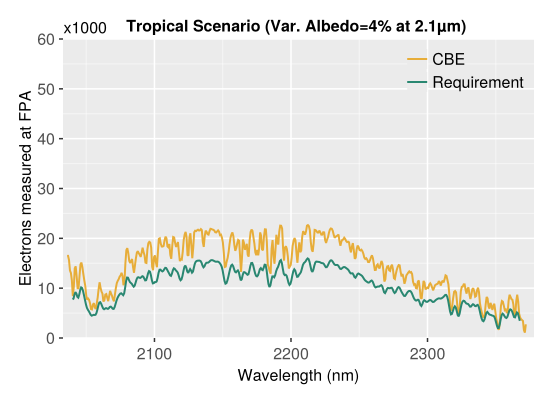

In [21]:
# Compute Electrons at FPA
e_cbe = InstrumentOperator.photons_at_fpa(ins_cbe, (cbe_specs.instrument_wl)u"nm", (F_cbe)u"mW/m^2/nm/sr");
e_req = InstrumentOperator.photons_at_fpa(ins_req, (req_specs.instrument_wl)u"nm", (F_req)u"mW/m^2/nm/sr");
from_w_to_photons = 5.03e12
refRadiance = 1.0e16 # in photons/s/m²/nm

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Electrons measured at FPA",  title="Tropical Scenario (Var. Albedo=4% at 2.1µm) ")
Label(f[1, 1, Top()], halign = :left, "x1000")
lines!(ax, cbe_specs.instrument_wl,e_cbe/1000, color=CarbonI_colors[1], linewidth=2, label="CBE")
lines!(ax, req_specs.instrument_wl,e_req/1000, color=CarbonI_colors[3], linewidth=2, label="Requirement")
#lines!(ax, [2035,2375], [refRadiance/ 1e16,refRadiance/ 1e16], color=:black, linestyle=:dash, linewidth=1, label="Reference Tropical Radiance")
xlims!(ax, 2033, 2378)
ylims!(ax, 0, 60)
axislegend(ax,position = :rt)
save("../../plots/final/Level1-3-TropicalScenario_FPA.pdf",f)
f

In [22]:
# Save Data for plotting
allData_fpa_cbe = [cbe_specs.instrument_wl e_cbe];
allData_fpa_req = [req_specs.instrument_wl e_req];
writedlm("../../data/L1s/Level1-3-BaselineScenario_FPA_CBE.csv", allData_fpa_cbe);
writedlm("../../data/L1s/Level1-3-BaselineScenario_FPA_Req.csv", allData_fpa_req);

---

### Probe phase space of instrument performance and impact on single measurement precision
Here, we iterate over readout noise and total system efficiency to derive the dependency of precision on instrument specs

---

### Uncertainty Budget for a Single Footprint

We linearize the radiative transfer around a reference state \(x_0\) and write the measurement model:

$$
y \;=\; F(x_0) \;+\; \mathbf{K}\,(x - x_0) \;+\; \varepsilon. \tag{D–4}
$$

Here, $ \mathbf{K} \equiv \partial F/\partial x $ is the Jacobian (spectral sensitivities) and $ \varepsilon \sim \mathcal{N}(0,\mathbf{S}_\varepsilon) $ is detector noise (shot + readout), which is computed mechanistically using our Instrument Model.

The posterior covariance of the retrieved state $ \hat{x} $ in a Bayesian estimator with prior $ \mathbf{S}_a $ is:

$$
\mathrm{Cov}(\hat{x}) \;=\; \hat{\mathbf{S}} \;=\; \big(\mathbf{K}^\top \mathbf{S}_\varepsilon^{-1}\mathbf{K} \;+\; \mathbf{S}_a^{-1}\big)^{-1}. \tag{D–5}
$$

For total columns $ \Omega_{\text{gas}} = \mathbf{h}_{\text{gas}}^\top \hat{x} $, the single-measurement precision follows:

$$
\sigma_s(\Omega_{\text{gas}}) \;=\; \sqrt{\mathbf{h}_{\text{gas}}^\top \hat{\mathbf{S}}\,\mathbf{h}_{\text{gas}}}. \tag{D–6}
$$

These expressions link instrument design (via $ \mathbf{K} $, spectral sampling, and SNR in $ \mathbf{S}_\varepsilon $) to per-footprint column precision used throughout the L1 derivations.

> With this setup, we can iterate through key instrument metrics and evaluate the impact on the retrieval precision 

In [23]:
# Now vary total efficiency at two different readout noise levels:

TotalEfficiencies = 0.3:0.05:1.0
n2o_errors_100 = zeros(length(TotalEfficiencies))
n2o_errors_120 = zeros(length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    
    # Store Data
    n2o_errors_100[i] = error_varied_100["n2o"]u"ppb"/background_vmr_n2o/sqrt(req_specs.coadd_rate)
    n2o_errors_120[i] = error_varied_120["n2o"]u"ppb"/background_vmr_n2o/sqrt(req_specs.coadd_rate) 
end

In [24]:
# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
efficiency_100 = LinearInterpolation(reverse(100(n2o_errors_100)), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120 = LinearInterpolation(reverse(100(n2o_errors_120)), reverse(TotalEfficiencies), extrapolation_bc=Line());

### Find driving requirement
here it is just for the relative error:

In [25]:
req_error        = 100*sigma_rel_SingleSounding_req / ampl

4.430941034496331

req_eff_120 = 0.4150721495376528


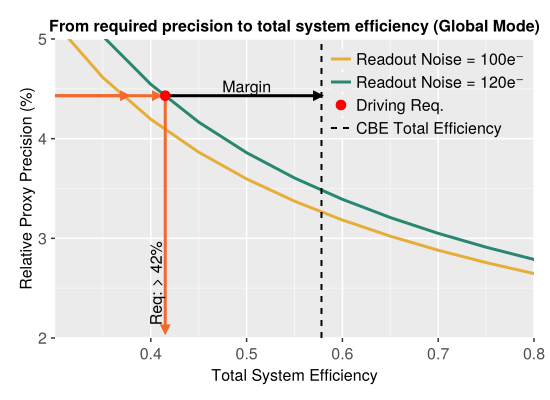

In [26]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Relative Proxy Precision (%)",  title="From required precision to total system efficiency (Global Mode)")
lines!(ax, TotalEfficiencies, n2o_errors_100*100, color=CarbonI_colors[1], linewidth=3, label="Readout Noise = 100e⁻")
lines!(ax, TotalEfficiencies, n2o_errors_120*100, color=CarbonI_colors[3], linewidth=3, label="Readout Noise = 120e⁻")

req_error        = 100*sigma_rel_SingleSounding_req /ampl
req_error_cbeGSD = 100*sigma_rel_SingleSounding_cbe /ampl
req_eff          = efficiency_100(req_error)
req_eff_120      = efficiency_120(req_error)

eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

arrows!(ax, [0.0,],[req_error,],[req_eff,],[0,],arrowsize = 15, linewidth=3,color = CarbonI_colors[5])
arrows!(ax, [0.0,],[req_error,],[req_eff_120-0.01,],[0,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [req_eff_120,],[req_error,],[eff_cbe-req_eff_120-0.005,],[0,],arrowsize = 15, linewidth=3, color = :black)
text!(ax, "Margin", position = (0.5, req_error),  align = (:center, :bottom), color = :black)
#arrows!(ax, [req_eff,],[req_error,],[0,],[-req_error+2.05,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
#text!(ax, "Req: > $(round(Int, 100req_eff))%", position = (req_eff, 2.5),
#    align = (:center, :bottom), color = :black, rotation=π/2)

arrows!(ax, [req_eff_120,],[req_error,],[0,],[-req_error+2.1,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])

scatter!(ax, [req_eff_120], [req_error], color=:red, markersize=15, label="Driving Req.")

text!(ax, "Req: > $(round(Int, 100req_eff_120))%", position = (req_eff_120, 2.55),
    align = (:center, :bottom), color = :black, rotation=π/2)
lines!(ax, [eff_cbe,eff_cbe], [2,6], color=:black, linestyle=:dash, linewidth=2, label="CBE Total Efficiency")
#arrows!(ax2, [req_percent_ch4,],[req_flux_ch4,],[-req_percent_ch4+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
#text!(ax2, "Req. >90%", position = (req_percent_ch4, 25),
#      align = (:center, :bottom), color = :black, rotation=π/2)

axislegend(ax,position = :rt)
xlims!(ax,0.3,0.8)
ylims!(ax,2,5)
@show req_eff_120
save("../../plots/final/Level1-3-EfficiencyDerivation.pdf",f)
f

In [27]:
# Save lines to merge later with other requirements:
AllData = [TotalEfficiencies n2o_errors_100*100 n2o_errors_120*100 ];

writedlm("../../data/L1s/L1-3_lines.dat", AllData)
writedlm("../../data/L1s/L1-3_req_error.dat", req_error)

In [28]:
ins_req_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", req_specs.Pitch, 1.0, req_eff_120, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current);
ins_cbe_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
# Use reference Wavelength here (just for conversion)
ref_wl = 2250;


refRadiance_mw = refRadiance / from_w_to_photons / ref_wl
nesr_req_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_req_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");
nesr_cbe_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_cbe_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");

@printf("Required SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m2/sr/nm/s: %.4g ",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

Required SNR @1e16 photons/m2/sr/nm/s: 80.3
CBE      SNR @1e16 photons/m2/sr/nm/s: 110.3 

---

### Compute performance of the CBE design

In [29]:
#ins_cbe_forProxy = InstrumentOperator.createGratingNoiseModel(57.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
ins_cbe_forProxy = InstrumentOperator.createGratingNoiseModel(57.0u"ms", cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

error_cbe_forProxy, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_forProxy, Sₐ_cbe, return_F=true) 
proxy_error_400m = error_cbe_forProxy["n2o"]u"ppb"/background_vmr_n2o/sqrt(req_specs.coadd_rate)
@printf("CBE Proxy Error at 400m (in percent): %.3g  \n", 100proxy_error_400m)

CBE Proxy Error at 400m (in percent): 3.12  


---

### Summary Stats:

In [34]:
# Computing CBE for L1-5:
proxy_error = error_cbe["n2o"]u"ppb"/background_vmr_n2o/sqrt(req_specs.coadd_rate)
sigma_rel_cbe_agg = proxy_error / sqrt(N_eff_global_cbe)

@printf("CBE Fractional Proxy Error: %.3g  \n", proxy_error)
@printf("CBE Standard Error for CH₄ : %.2g ppb\n", sigma_rel_cbe_agg*ustrip(background_vmr_ch4)) 
@printf("CBE Standard Error for CO₂ : %.2g ppm\n", sigma_rel_cbe_agg*ustrip(background_vmr_co2))
@printf("CBE Standard Error for CO  : %.2g ppb\n", error_cbe["co"]/ sqrt(N_eff_global_cbe) / sqrt(req_specs.coadd_rate))

# From before:
@printf("Required relative error in σ_agg : %.3g percent\n", 100*sigma_rel_agg_global_req)
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)
@printf("Required Single Measurement Precision for CO in ppb for REQ specs: %.3g\n", ustrip(sigma_co_SingleSounding_req))

# Total System Efficiency
@printf("Required Total System Efficiency: %.5g\n", req_eff_120)

# Pixels:
# Pixels:
@printf("Number of cloud-free Pixel in Required GSD: %.3g\n", N_eff_global_req)
@printf("Number of cloud-free Pixel in CBE GSD: %.3g\n", N_eff_global_cbe)

CBE Fractional Proxy Error: 0.0371  
CBE Standard Error for CH₄ : 8.2 ppb
CBE Standard Error for CO₂ : 1.8 ppm
CBE Standard Error for CO  : 4.1 ppb
Required relative error in σ_agg : 0.737 percent
Required Single Measurement Precision for N₂O in percent for req. GSD : 4.48
Required Single Measurement Precision for N₂O in percent for CBE specs: 6.3
Required Single Measurement Precision for CO in ppb for REQ specs: 60.7
Required Total System Efficiency: 0.41507
Number of cloud-free Pixel in Required GSD: 36.9
Number of cloud-free Pixel in CBE GSD: 73.2


### The End